<a href="https://colab.research.google.com/github/abhijadhav14/F1-Predictions/blob/main/F1_Drivers_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


In [3]:
import os
import fastf1
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)

In [6]:
def fetch_driver_performance_data(year, rounds):
    """
    Fetch comprehensive driver performance metrics for specified races
    """
    all_data = []

    for round_num in rounds:
        try:
            print(f"Fetching round {round_num} of {year}...")


            race = fastf1.get_session(year, round_num, 'R')
            race.load()
            quali = fastf1.get_session(year, round_num, 'Q')
            quali.load()


            for _, driver_result in race.results.iterrows():
                try:
                    driver_number = driver_result.DriverNumber
                    team = driver_result.TeamName
                    driver_name = driver_result.FullName


                    teammate_data = race.results[
                        (race.results['TeamName'] == team) &
                        (race.results['DriverNumber'] != driver_number)
                    ].iloc[0]


                    quali_data = quali.results[quali.results['DriverNumber'] == driver_number].iloc[0]
                    teammate_quali = quali.results[quali.results['DriverNumber'] == teammate_data['DriverNumber']].iloc[0]

                    race_data = {
                        'Round': round_num,
                        'Driver': driver_name,
                        'Team': team,
                        'Points': float(driver_result.Points),
                        'QualiPosition': float(quali_data.Position),
                        'TeammateQualiPosition': float(teammate_quali.Position),
                        'GridPosition': float(driver_result.GridPosition),
                        'FinishPosition': float(driver_result.Position),
                        'TeammateFinishPosition': float(teammate_data.Position),
                        'PositionsGained': float(driver_result.GridPosition) - float(driver_result.Position),
                        'DNF': 1 if driver_result.Status != 'Finished' else 0,
                        'FastestLapPoint': 1 if getattr(driver_result, 'FastestLap', False) else 0,
                        'PitStops': len(race.laps.pick_driver(driver_number)['PitOutTime'].dropna())
                    }


                    all_data.append(race_data)
                    print(f"Successfully processed data for {driver_name}")

                except Exception as e:
                    print(f"Error processing driver data: {e}")
                    continue

        except Exception as e:
            print(f"Error processing round {round_num}: {e}")
            continue

    if not all_data:
        raise Exception("No data could be collected!")

    return pd.DataFrame(all_data)

In [7]:
def prepare_features(df):
    """
    Prepare features for the model, excluding team-dependent metrics and driver names
    """
    features = [
        'QualiPosition',
        'TeammateQualiPosition',
        'GridPosition',
        'TeammateFinishPosition',
        'PositionsGained',
        'DNF',
        'FastestLapPoint',
        'PitStops'
    ]

    X = df[features]
    y = df['Points']


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=features), y

In [8]:
def train_points_predictor(X, y):
    """
    Train a Random Forest model to predict points based on performance metrics
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nModel Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")


    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    return model

In [9]:
def analyze_driver_ratings(df, model, X):
    """
    Compare predicted vs actual points with detailed analysis over multiple races
    """
    df['PredictedPoints'] = model.predict(X)
    df['PointsDifference'] = df['PredictedPoints'] - df['Points']


    driver_stats = df.groupby('Driver').agg({
        'Points': ['mean', 'sum'],
        'PredictedPoints': ['mean', 'sum'],
        'PointsDifference': ['mean', 'sum'],
        'Team': 'first'
    }).round(2)

    driver_stats.columns = ['AvgPoints', 'TotalPoints', 'AvgPredicted',
                          'TotalPredicted', 'AvgDiff', 'TotalDiff', 'Team']

    driver_stats = driver_stats.sort_values('TotalDiff', ascending=False)

    print("\n📊 DRIVER PERFORMANCE ANALYSIS")
    print("=" * 100)


    print("\n🏆 TOP 3 MOST UNDERRATED DRIVERS:")
    print("-" * 50)
    for idx, row in driver_stats[driver_stats['TotalDiff'] > 0].head(3).iterrows():
        print(f"\n{idx} ({row['Team']}):")
        print(f"  Average Points per Race: {row['AvgPoints']:.1f}")
        print(f"  Average Predicted Points: {row['AvgPredicted']:.1f}")
        print(f"  Total Points: {row['TotalPoints']:.1f}")
        print(f"  Total Predicted: {row['TotalPredicted']:.1f}")
        print(f"  Underrated by: {row['TotalDiff']:.1f} points total")
        print(f"  ({row['AvgDiff']:.1f} points per race)")


    print("\n📉 TOP 3 MOST OVERRATED DRIVERS:")
    print("-" * 50)
    for idx, row in driver_stats[driver_stats['TotalDiff'] < 0].head(3).iterrows():
        print(f"\n{idx} ({row['Team']}):")
        print(f"  Average Points per Race: {row['AvgPoints']:.1f}")
        print(f"  Average Predicted Points: {row['AvgPredicted']:.1f}")
        print(f"  Total Points: {row['TotalPoints']:.1f}")
        print(f"  Total Predicted: {row['TotalPredicted']:.1f}")
        print(f"  Overrated by: {abs(row['TotalDiff']):.1f} points total")
        print(f"  ({abs(row['AvgDiff']):.1f} points per race)")


    plt.figure(figsize=(15, 10))


    plt.subplot(2, 1, 1)
    for driver in driver_stats.index[:5]:  # Top 5 drivers
        driver_data = df[df['Driver'] == driver]
        plt.plot(driver_data['Round'], driver_data['PointsDifference'],
                marker='o', label=driver)

    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Race Number')
    plt.ylabel('Points Difference')
    plt.title('Points Difference Trend (Top 5 Drivers)')
    plt.legend()


    plt.subplot(2, 1, 2)
    colors = ['g' if x > 0 else 'r' for x in driver_stats['TotalDiff']]
    plt.bar(driver_stats.index, driver_stats['TotalDiff'], color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.title('Total Points Difference (Predicted - Actual)')
    plt.xlabel('Driver')
    plt.ylabel('Points Difference')

    plt.tight_layout()
    plt.show()

Fetching F1 training data...

Fetching 2023 race data (last 7 races)...
Fetching round 16 of 2023...


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status

Successfully processed data for Max Verstappen
Successfully processed data for Lando Norris
Successfully processed data for Oscar Piastri
Successfully processed data for Charles Leclerc
Successfully processed data for Lewis Hamilton
Successfully processed data for Carlos Sainz
Successfully processed data for George Russell
Successfully processed data for Fernando Alonso
Successfully processed data for Esteban Ocon
Successfully processed data for Pierre Gasly
Successfully processed data for Liam Lawson
Successfully processed data for Yuki Tsunoda
Successfully processed data for Guanyu Zhou
Successfully processed data for Nico Hulkenberg
Successfully processed data for Kevin Magnussen
Successfully processed data for Alexander Albon
Successfully processed data for Logan Sargeant
Successfully processed data for Lance Stroll
Successfully processed data for Sergio Perez
Successfully processed data for Valtteri Bottas
Successfully added 2023 Round 16
Fetching round 17 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
INFO:fastf1.api:Fetching lap count data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api

Successfully processed data for Max Verstappen
Successfully processed data for Oscar Piastri
Successfully processed data for Lando Norris
Successfully processed data for George Russell
Successfully processed data for Charles Leclerc
Successfully processed data for Fernando Alonso
Successfully processed data for Esteban Ocon
Successfully processed data for Valtteri Bottas
Successfully processed data for Guanyu Zhou
Successfully processed data for Sergio Perez
Successfully processed data for Lance Stroll
Successfully processed data for Pierre Gasly
Successfully processed data for Alexander Albon
Successfully processed data for Kevin Magnussen
Successfully processed data for Yuki Tsunoda
Successfully processed data for Nico Hulkenberg
Successfully processed data for Liam Lawson
Successfully processed data for Logan Sargeant
Successfully processed data for Lewis Hamilton
Successfully processed data for Carlos Sainz
Successfully added 2023 Round 17
Fetching round 18 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	F

Successfully processed data for Max Verstappen
Successfully processed data for Lando Norris
Successfully processed data for Carlos Sainz
Successfully processed data for Sergio Perez
Successfully processed data for George Russell
Successfully processed data for Pierre Gasly
Successfully processed data for Lance Stroll
Successfully processed data for Yuki Tsunoda
Successfully processed data for Alexander Albon
Successfully processed data for Logan Sargeant
Successfully processed data for Nico Hulkenberg
Successfully processed data for Valtteri Bottas
Successfully processed data for Guanyu Zhou
Successfully processed data for Kevin Magnussen
Successfully processed data for Daniel Ricciardo
Successfully processed data for Fernando Alonso
Successfully processed data for Oscar Piastri
Successfully processed data for Esteban Ocon
Successfully processed data for Lewis Hamilton
Successfully processed data for Charles Leclerc
Successfully added 2023 Round 18
Fetching round 19 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
INFO:fastf1.api:Fetching lap count data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...
_api

Successfully processed data for Max Verstappen
Successfully processed data for Lewis Hamilton
Successfully processed data for Charles Leclerc
Successfully processed data for Carlos Sainz
Successfully processed data for Lando Norris
Successfully processed data for George Russell
Successfully processed data for Daniel Ricciardo
Successfully processed data for Oscar Piastri
Successfully processed data for Alexander Albon
Successfully processed data for Esteban Ocon
Successfully processed data for Pierre Gasly
Successfully processed data for Yuki Tsunoda
Successfully processed data for Nico Hulkenberg
Successfully processed data for Guanyu Zhou
Successfully processed data for Valtteri Bottas
Successfully processed data for Logan Sargeant
Successfully processed data for Lance Stroll
Successfully processed data for Fernando Alonso
Successfully processed data for Kevin Magnussen
Successfully processed data for Sergio Perez
Successfully added 2023 Round 19
Fetching round 20 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	F

Successfully processed data for Max Verstappen
Successfully processed data for Lando Norris
Successfully processed data for Fernando Alonso
Successfully processed data for Sergio Perez
Successfully processed data for Lance Stroll
Successfully processed data for Carlos Sainz
Successfully processed data for Pierre Gasly
Successfully processed data for Lewis Hamilton
Successfully processed data for Yuki Tsunoda
Successfully processed data for Esteban Ocon
Successfully processed data for Logan Sargeant
Successfully processed data for Nico Hulkenberg
Successfully processed data for Daniel Ricciardo
Successfully processed data for Oscar Piastri
Successfully processed data for George Russell
Successfully processed data for Valtteri Bottas
Successfully processed data for Guanyu Zhou
Successfully processed data for Kevin Magnussen
Successfully processed data for Alexander Albon
Successfully processed data for Charles Leclerc
Successfully added 2023 Round 20
Fetching round 21 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:54:30.642' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:35.501' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req       

Successfully processed data for Max Verstappen
Successfully processed data for Charles Leclerc
Successfully processed data for Sergio Perez
Successfully processed data for Esteban Ocon
Successfully processed data for Lance Stroll
Successfully processed data for Carlos Sainz
Successfully processed data for Lewis Hamilton
Successfully processed data for George Russell
Successfully processed data for Fernando Alonso
Successfully processed data for Oscar Piastri
Successfully processed data for Pierre Gasly
Successfully processed data for Alexander Albon
Successfully processed data for Kevin Magnussen
Successfully processed data for Daniel Ricciardo
Successfully processed data for Guanyu Zhou
Successfully processed data for Logan Sargeant
Successfully processed data for Valtteri Bottas
Successfully processed data for Yuki Tsunoda
Successfully processed data for Nico Hulkenberg
Successfully processed data for Lando Norris
Successfully added 2023 Round 21
Fetching round 22 of 2023...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:59:48.299' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf

Successfully processed data for Max Verstappen
Successfully processed data for Charles Leclerc
Successfully processed data for George Russell
Successfully processed data for Sergio Perez
Successfully processed data for Lando Norris
Successfully processed data for Oscar Piastri
Successfully processed data for Fernando Alonso
Successfully processed data for Yuki Tsunoda
Successfully processed data for Lewis Hamilton
Successfully processed data for Lance Stroll
Successfully processed data for Daniel Ricciardo
Successfully processed data for Esteban Ocon
Successfully processed data for Pierre Gasly
Successfully processed data for Alexander Albon
Successfully processed data for Nico Hulkenberg
Successfully processed data for Logan Sargeant
Successfully processed data for Guanyu Zhou
Successfully processed data for Carlos Sainz
Successfully processed data for Valtteri Bottas
Successfully processed data for Kevin Magnussen
Successfully added 2023 Round 22

Fetching 2024 race data (first 3 rac

req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	F

Successfully processed data for Max Verstappen
Successfully processed data for Sergio Perez
Successfully processed data for Carlos Sainz
Successfully processed data for Charles Leclerc
Successfully processed data for George Russell
Successfully processed data for Lando Norris
Successfully processed data for Lewis Hamilton
Successfully processed data for Oscar Piastri
Successfully processed data for Fernando Alonso
Successfully processed data for Lance Stroll
Successfully processed data for Guanyu Zhou
Successfully processed data for Kevin Magnussen
Successfully processed data for Daniel Ricciardo
Successfully processed data for Yuki Tsunoda
Successfully processed data for Alexander Albon
Successfully processed data for Nico Hulkenberg
Successfully processed data for Esteban Ocon
Successfully processed data for Pierre Gasly
Successfully processed data for Valtteri Bottas
Successfully processed data for Logan Sargeant
Successfully added 2024 Round 1
Fetching round 2 of 2024...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...
_api           INFO 	F

Successfully processed data for Max Verstappen
Successfully processed data for Sergio Perez
Successfully processed data for Charles Leclerc
Successfully processed data for Oscar Piastri
Successfully processed data for Fernando Alonso
Successfully processed data for George Russell
Successfully processed data for Oliver Bearman
Successfully processed data for Lando Norris
Successfully processed data for Lewis Hamilton
Successfully processed data for Nico Hulkenberg
Successfully processed data for Alexander Albon
Successfully processed data for Kevin Magnussen
Successfully processed data for Esteban Ocon
Successfully processed data for Logan Sargeant
Successfully processed data for Yuki Tsunoda
Successfully processed data for Daniel Ricciardo
Successfully processed data for Valtteri Bottas
Successfully processed data for Guanyu Zhou
Successfully processed data for Lance Stroll
Successfully processed data for Pierre Gasly
Successfully added 2024 Round 2
Fetching round 3 of 2024...


req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:57:37.891' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
INFO:fastf1.fastf

Successfully processed data for Carlos Sainz
Successfully processed data for Charles Leclerc
Successfully processed data for Lando Norris
Successfully processed data for Oscar Piastri
Successfully processed data for Sergio Perez
Successfully processed data for Lance Stroll
Successfully processed data for Yuki Tsunoda
Successfully processed data for Fernando Alonso
Successfully processed data for Nico Hulkenberg
Successfully processed data for Kevin Magnussen
Error processing driver data: single positional indexer is out-of-bounds
Successfully processed data for Daniel Ricciardo
Successfully processed data for Pierre Gasly
Successfully processed data for Valtteri Bottas
Successfully processed data for Guanyu Zhou
Successfully processed data for Esteban Ocon
Successfully processed data for George Russell
Successfully processed data for Lewis Hamilton
Successfully processed data for Max Verstappen
Successfully added 2024 Round 3

Total races collected: 10
Total driver entries: 198

Model 

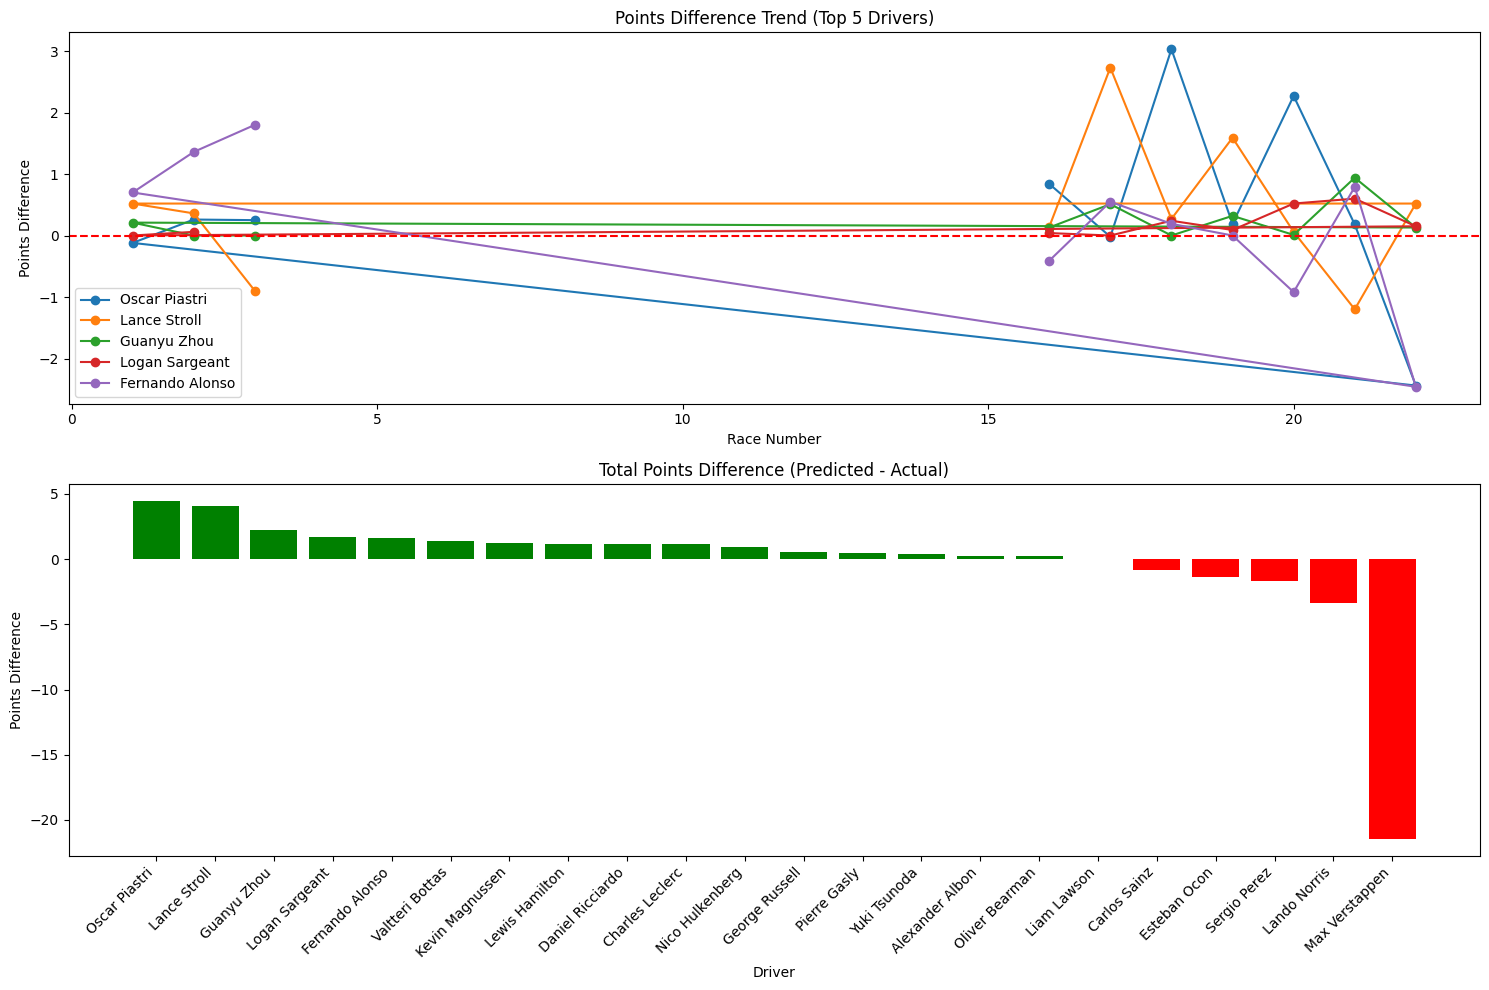

In [10]:
def main():
    print("Fetching F1 training data...")
    all_data = []

    try:

        print("\nFetching 2023 race data (last 7 races)...")
        for round_num in range(16, 23):  # Races 16-22 from 2023
            try:
                data_2023 = fetch_driver_performance_data(2023, [round_num])
                if data_2023 is not None and not data_2023.empty:
                    all_data.append(data_2023)
                    print(f"Successfully added 2023 Round {round_num}")
            except Exception as e:
                print(f"Couldn't fetch 2023 Round {round_num}: {e}")


        print("\nFetching 2024 race data (first 3 races)...")
        for round_num in range(1, 4):
            try:
                data_2024 = fetch_driver_performance_data(2024, [round_num])
                if data_2024 is not None and not data_2024.empty:
                    all_data.append(data_2024)
                    print(f"Successfully added 2024 Round {round_num}")
            except Exception as e:
                print(f"Couldn't fetch 2024 Round {round_num}: {e}")

        if all_data:
            # Combine all the data
            combined_data = pd.concat(all_data, ignore_index=True)
            print(f"\nTotal races collected: {len(combined_data['Round'].unique())}")
            print(f"Total driver entries: {len(combined_data)}")


            # Prepare features and train model
            X, y = prepare_features(combined_data)
            model = train_points_predictor(X, y)

            # Analyze driver ratings
            print("\nAnalyzing driver performance across all collected races...")
            analyze_driver_ratings(combined_data, model, X)

        else:
            print("Could not fetch enough data!")

    except Exception as e:
        print(f"Error in main execution: {e}")

if __name__ == "__main__":
    main()